

# **📊 Exploratory Data Analysis (EDA) — Structured by Subtasks**

---

# **1. Descriptive Statistics**

### **1.1 Headline Length Statistics**

**Goal:** Understand how long news headlines typically are.

**What to analyze:**

* Compute headline length in:

  * characters
  * words
* Generate summary statistics:

  * mean, median, min, max, standard deviation
* Plot histogram of headline lengths.

**Insights you can expect:**

* Short headlines often indicate breaking news.
* Longer headlines often include context (e.g., earnings reports or analyst commentary).

---

### **1.2 Article Count per Publisher**

**Goal:** Identify the most active information sources.

**What to compute:**

* Count number of articles per publisher.
* Sort in descending order.
* Visualize top publishers using a bar chart.

**Insights you can expect:**

* You may see heavy dominance from large outlets (e.g., Reuters, MarketWatch).
* A few publishers may account for most news, which affects sentiment bias.

---

### **1.3 Date-Based Trends**

**Goal:** Explore how publishing activity changes over time.

**What to analyze:**

* Number of articles published:

  * per day
  * per week
  * per month
* Identify:

  * spikes during earnings season
  * high-frequency days (e.g., Mondays)
  * periods of market turbulence (e.g., inflation reports, rate hikes)

**Insights you can expect:**

* News volume increases around major events (e.g., quarterly earnings).
* Fridays might show drops, while Monday spikes are common.

---

# **2. Text Analysis (Topic Modeling)**

### **2.1 Keyword Frequency**

**Goal:** Identify dominant themes in the news.

**Methods:**

* Tokenization & cleaning
* Remove stop words, numbers, special characters
* Generate:

  * word frequency table
  * word cloud (optional)
  * n-grams (bigrams, trigrams)

**Expected keywords:**

* “stock”, “price target”, “earnings”, “downgrade”, “merger”, “acquisition”.

---

### **2.2 Topic Modeling (LDA)**

**Goal:** Group headlines into meaningful **topics**.

**Outputs might look like:**

* **Topic 1: Earnings News**
  Keywords: earnings, quarterly, revenue, profit, forecast
* **Topic 2: Analyst Actions**
  Keywords: upgrade, downgrade, price target, rating
* **Topic 3: Market Movers**
  Keywords: surge, plunge, futures, rally
* **Topic 4: Legal/Regulatory**
  Keywords: lawsuit, regulation, FTC, approval, FDA

**Insight:**
Topic modeling helps link **sentiment** to **types of events**.

---

# **3. Time Series Analysis**

### **3.1 Publication Frequency Over Time**

**Goal:** Visualize how often news is published.

**Steps:**

* Convert date column to datetime.
* Resample:

  * Daily count
  * Weekly count
  * Monthly count
* Plot time series curve.

**Insights:**

* Sudden spikes highlight important macro events.
* Regular periodic patterns might show corporate cycles.

---

### **3.2 Publishing Time of Day**

**Goal:** Understand hourly behavior of news publishers.

**Steps:**

* Extract hour from timestamp (UTC-4).
* Count articles per hour.
* Plot distribution.

**Insights you may observe:**

* Majority of articles appear between **8:00–11:00 AM EST**, aligning with:

  * Pre-market trading
  * Market open (9:30 AM)
* Very few headlines appear late night (00:00–05:00).

**Usefulness:**

* Helps traders time automated alert systems.

---

### **3.3 Time Series Seasonality**

**Optional deeper-level analysis:**

* Decomposition into:

  * trend
  * seasonality
  * residual
* Helps understand if news volume is cyclical.

---

# **4. Publisher Analysis**

### **4.1 Most Active Publishers**

**Goal:** Determine which publishers dominate the dataset.

**Steps:**

* Rank publishers by article count.
* Visualize top 10 publishers.

**Possible findings:**

* Financial newswire services lead (e.g., Reuters, Bloomberg).
* Smaller blogs show low frequency but cross-sectional stock coverage.

---

### **4.2 Type of News Reported by Publishers**

**Goal:** Check if publishers specialize in different content.

**Approach:**

* For each publisher:

  * Perform keyword frequency analysis
  * Measure average sentiment score (later stage)
  * Identify typical topics they publish (earnings, ratings, political news)

**Example Expected Output:**

* Reuters → breaking news, market-moving events
* MarketWatch → analytical articles, commentary
* Yahoo Finance → general coverage, trending topics

---

### **4.3 Email-Domain-Based Analysis (If publishers contain emails)**

**Goal:** Identify contributing organizations.

**Steps:**

* Extract domain from publisher email (`split after @`)
* Count domain frequency

**Insights:**

* A single company might have multiple contributors.
* Some domains might indicate internal financial communities.

---

# **✔ Final EDA Summary Structure (Your Report Should Include):**

1. **Descriptive Statistics**

   * Headline length metrics
   * Publisher frequency
   * Date-based trends

2. **Text Analysis (Topic Modeling)**

   * Keyword frequencies
   * Bigram/trigram extraction
   * LDA topic modeling

3. **Time Series Analysis**

   * Publication frequency over time
   * Hourly publication patterns
   * Seasonal patterns (optional)

4. **Publisher Analysis**

   * Most active publishers
   * Content type differences
   * Domain-level aggregation (if emails exist)

---

If you want, I can also:
✅ Write full Python code for each section
✅ Generate plots (matplotlib)
✅ Help you build the final EDA report
Just tell me **"give me the code"** or **"generate the report"**.


In [1]:

import os
import re
from collections import Counter
import pandas as pd
import numpy as np
from dateutil import tz
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from gensim.models.ldamulticore import LdaMulticore
from tqdm import tqdm

# NLP
from nltk.corpus import stopwords
import nltk

# gensim and sklearn
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# ---------------------------
# NLTK setup
# ---------------------------
# Only download stopwords once
nltk.download('stopwords')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zkidanemariam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Configuration

In [2]:

# Notebook is in "nova-financial-solutions/notebooks", so one level up is project root
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)  # one level up

# Paths
DATA_DIR = os.path.join(BASE_DIR, "data")  # points to nova-financial-solutions/data
OUTPUT_DIR = os.path.join(BASE_DIR, "notebook", "task-1-eda_outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

COL_HEADLINE = "headline"
COL_PUBLISHER = "publisher"
COL_DATE = "date"
COL_STOCK = "stock"

INPUT_TZ = tz.gettz("Etc/GMT+4")
TARGET_TZ = tz.tzutc()

# CSV path
DATA_PATH = os.path.join(DATA_DIR, "raw_analyst_ratings.csv")
print("BASE_DIR:", BASE_DIR)
print("DATA_PATH:", DATA_PATH)
print("File exists:", os.path.exists(DATA_PATH))

BASE_DIR: C:\Users\zkidanemariam\Documents\pers\10 academy\projects\nova-financial-solutions
DATA_PATH: C:\Users\zkidanemariam\Documents\pers\10 academy\projects\nova-financial-solutions\data\raw_analyst_ratings.csv
File exists: True


# Utility Functions

In [3]:

def safe_str(s):
    return "" if pd.isna(s) else str(s)

def extract_email_domain(publisher_str):
    s = safe_str(publisher_str)
    if "@" in s:
        try:
            return s.split("@", 1)[1].lower()
        except:
            return None
    return None

def clean_text(text):
    text = safe_str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load Dataset

In [4]:

DATA_PATH = os.path.join(BASE_DIR, "data", "raw_analyst_ratings.csv")
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df):,} rows.")
# Parse datetime
df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors='coerce')
df[COL_DATE] = df[COL_DATE].apply(
    lambda dt: pd.NaT if pd.isna(dt) else dt.tz_localize(INPUT_TZ) if dt.tzinfo is None else dt.astimezone(INPUT_TZ)
)
df['date_utc'] = df[COL_DATE].apply(lambda dt: dt.astimezone(TARGET_TZ) if not pd.isna(dt) else pd.NaT)
df['date_local'] = df['date_utc']
df['date_ymd'] = df['date_local'].dt.date
df['date_day'] = df['date_local'].dt.floor('D')
df['date_hour'] = df['date_local'].dt.hour

Loaded 1,407,328 rows.


# Descriptive Statistics

In [7]:
print("Running Descriptive Statistics...")


df['headline_text'] = df[COL_HEADLINE].fillna("").astype(str)
df['headline_len_chars'] = df['headline_text'].str.len()
df['headline_len_words'] = df['headline_text'].str.split().apply(len)

# Summary CSVs
df['headline_len_chars'].describe().to_csv(os.path.join(OUTPUT_DIR, "headline_len_chars_summary.csv"))
df['headline_len_words'].describe().to_csv(os.path.join(OUTPUT_DIR, "headline_len_words_summary.csv"))



Running Descriptive Statistics...


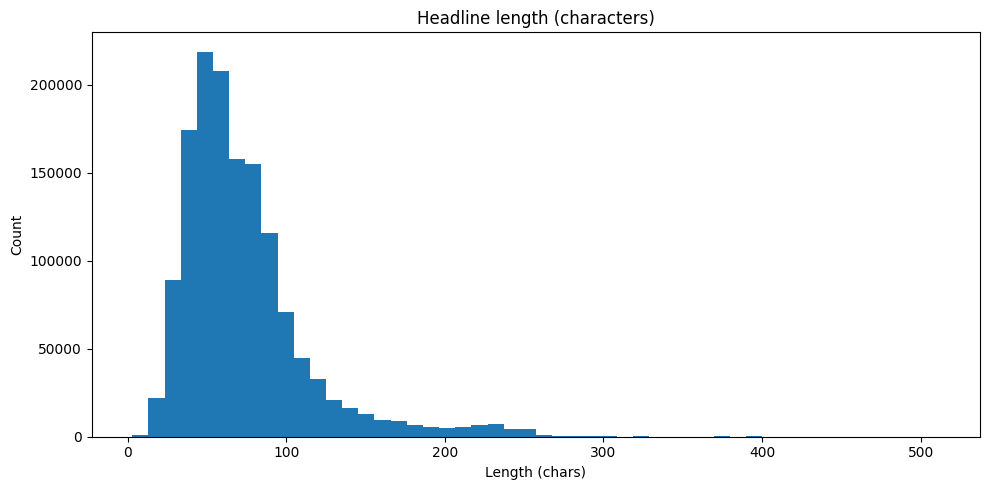

In [8]:

plt.figure(figsize=(10,5))
plt.hist(df['headline_len_chars'].dropna(), bins=50)
plt.title("Headline length (characters)")
plt.xlabel("Length (chars)")
plt.ylabel("Count")
plt.tight_layout()

# Save to file
plt.savefig(os.path.join(OUTPUT_DIR, "headline_len_chars_histogram.png"))

# Display inline
plt.show()   # <- this will show the plot in the notebook


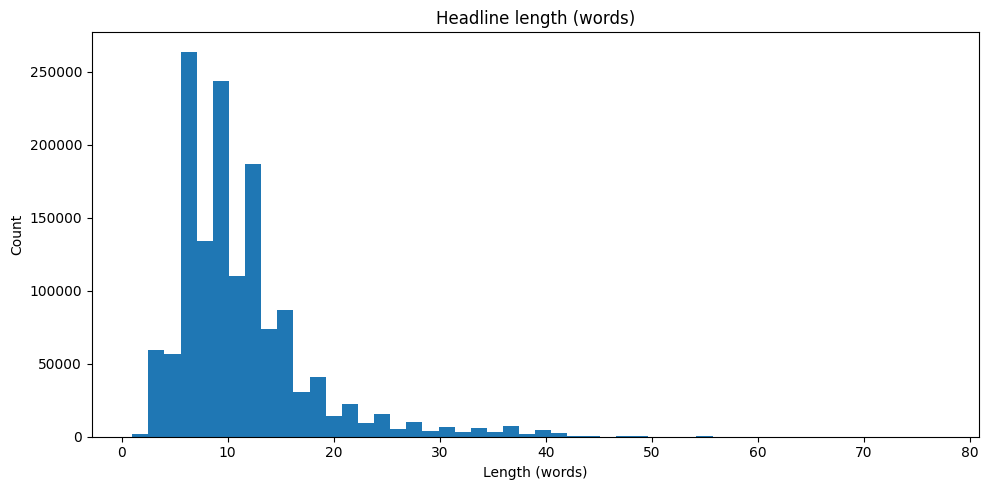

In [9]:

# Plot histograms
plt.figure(figsize=(10,5))
plt.hist(df['headline_len_words'].dropna(), bins=50)
plt.title("Headline length (words)")
plt.xlabel("Length (words)")
plt.ylabel("Count")
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(OUTPUT_DIR, "headline_len_words_histogram.png"))

# Show the plot in the notebook
plt.show()

In [10]:

# Publisher counts
publisher_counts = df[COL_PUBLISHER].fillna("UNKNOWN").value_counts()
publisher_counts.head(50).to_csv(os.path.join(OUTPUT_DIR, "publisher_counts_top50.csv"))

# Time Series Analysis

In [11]:
print("Running Time Series Analysis...")

df_ts = df.set_index('date_local')
daily_counts = df_ts.resample('D').size()
daily_counts.to_csv(os.path.join(OUTPUT_DIR, "daily_counts.csv"))

Running Time Series Analysis...


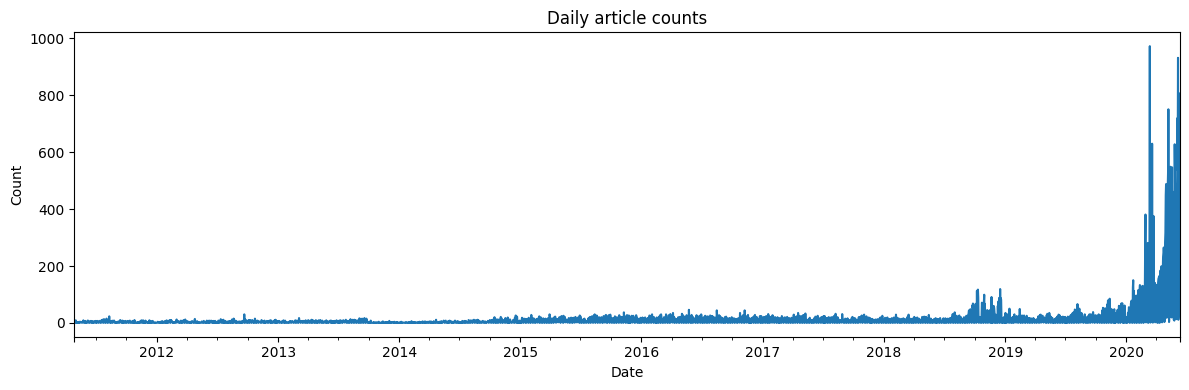

In [12]:
plt.figure(figsize=(12,4))
daily_counts.plot()
plt.title("Daily article counts")
plt.xlabel("Date")
plt.ylabel("Count")
plt.tight_layout()

# Save to file
plt.savefig(os.path.join(OUTPUT_DIR, "daily_article_counts.png"))

# Show inline in notebook
plt.show()


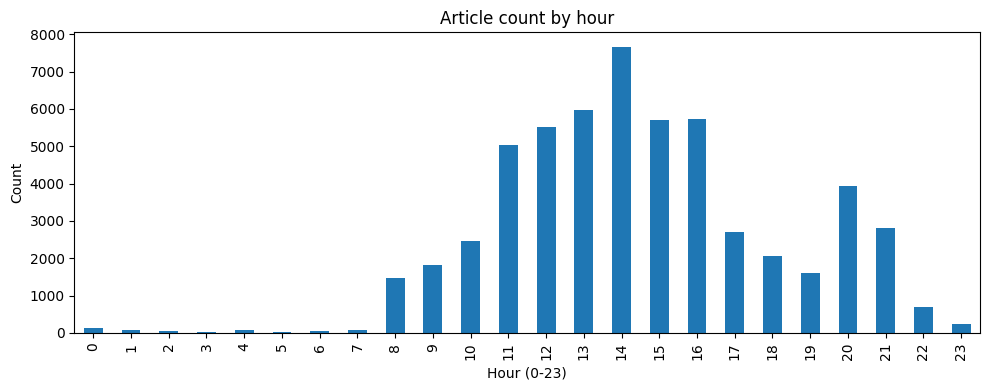

In [13]:
hourly_counts = df.groupby('date_hour').size().reindex(range(24), fill_value=0)
hourly_counts.to_csv(os.path.join(OUTPUT_DIR, "hourly_counts.csv"))

plt.figure(figsize=(10,4))
hourly_counts.plot(kind='bar')
plt.title("Article count by hour")
plt.xlabel("Hour (0-23)")
plt.ylabel("Count")
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(OUTPUT_DIR, "hourly_counts_bar.png"))

# Display inline in notebook
plt.show()

# Text Analysis

Running Text Analysis...


Tokenizing: 100%|███████████████████████████████████████████| 1407328/1407328 [00:06<00:00, 204039.99it/s]


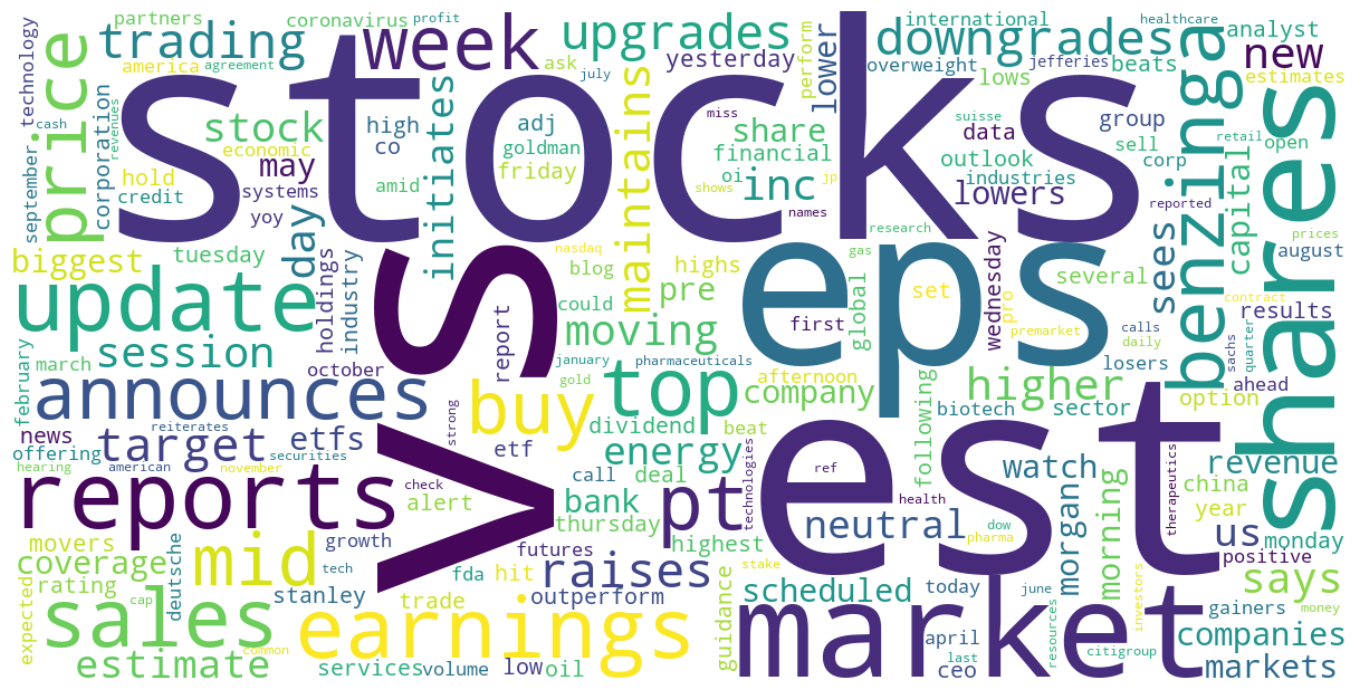

In [15]:
# ---------------------------
# Text Cleaning & Tokenization
# ---------------------------

def clean_text(text):
    text = "" if pd.isna(text) else str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Stopwords setup
stop = set(stopwords.words('english'))
stop.update({'reuters', 'bloomberg', 'via'})

# Regex-based tokenizer (no NLTK punkt dependency)
def tokenize_keep(text):
    toks = re.findall(r'\b[a-z]{2,}\b', text.lower())
    toks = [t for t in toks if t not in stop]
    return toks

# ---------------------------
# Apply to dataframe
# ---------------------------
print("Running Text Analysis...")

# Clean headlines
df['headline_clean'] = df['headline_text'].apply(clean_text)

# Tokenize
tqdm.pandas(desc="Tokenizing")
df['tokens'] = df['headline_clean'].progress_apply(tokenize_keep)

# Word frequency
all_tokens = [t for toks in df['tokens'] for t in toks]
word_freq = Counter(all_tokens)
pd.DataFrame(word_freq.most_common(50), columns=['word','count']).to_csv(
    os.path.join(OUTPUT_DIR, "word_freq_top50.csv")
)

# ---------------------------
# WordCloud
# ---------------------------
wc = WordCloud(width=1200, height=600, background_color="white")
wc.generate_from_frequencies(dict(word_freq.most_common(500)))

# Save and show
wc.to_file(os.path.join(OUTPUT_DIR, "wordcloud_headlines.png"))

plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()



# Publisher Analysis

In [ ]:
from gensim.models.ldamulticore import LdaMulticore
from tqdm import tqdm

print("Running LDA Topic Modeling with progress bar...")

texts = df['tokens'].tolist()
print(f"Total documents: {len(texts)}")

# Create dictionary and filter extremes
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
print(f"Dictionary size after filtering: {len(dictionary)}")

# Convert all docs to BoW (list, not generator!)
print("Converting documents to BoW...")
corpus = [dictionary.doc2bow(doc) for doc in tqdm(texts, desc="BoW conversion")]

NUM_TOPICS = 6
CHUNKSIZE = 10000
PASSES = 5
WORKERS = 4

if len(dictionary) >= 10:
    print(f"Training LDA with {NUM_TOPICS} topics using {WORKERS} cores...")

    lda = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=NUM_TOPICS,
        passes=PASSES,
        chunksize=CHUNKSIZE,
        workers=WORKERS,
        random_state=42,
        batch=True
    )

    # Save topics
    topics_out = []
    for tid in range(NUM_TOPICS):
        terms = lda.show_topic(tid, topn=12)
        topics_out.append((tid, " ".join([f"{w}:{round(prob,3)}" for w, prob in terms])))
        print(f"Topic {tid} top terms: {topics_out[-1][1]}")

    pd.DataFrame(topics_out, columns=['topic_id','top_terms']).to_csv(
        os.path.join(OUTPUT_DIR, "lda_topics.csv"), index=False
    )

    # Assign top topic per document
    print("Assigning top topic to each headline...")
    doc_topics = [lda.get_document_topics(bow) for bow in tqdm(corpus, desc="Assigning topics")]
    top_topics = [max(d,key=lambda x:x[1])[0] if d else -1 for d in doc_topics]
    df['lda_top_topic'] = top_topics
    df[['headline_text','lda_top_topic']].to_csv(
        os.path.join(OUTPUT_DIR, "headlines_with_top_topic.csv"), index=False
    )

print("LDA Topic Modeling completed.")



Running LDA Topic Modeling with progress bar...
Total documents: 1407328
Dictionary size after filtering: 35017
Converting documents to BoW...


BoW conversion: 100%|███████████████████████████████████████| 1407328/1407328 [00:07<00:00, 189620.67it/s]


Training LDA with 6 topics using 4 cores...
